Version 1.6, 14 May 2024

STORM Track dataset details: 

https://www.nature.com/articles/s41597-020-0381-2

https://doi.org/10.4121/uuid:82c1dc0d-5485-43d8-901a-ce7f26cda35d

https://data.4tu.nl/articles/STORM_IBTrACS_present_climate_synthetic_tropical_cyclone_tracks/12706085?file=24876980

The 10,000 year TC STORM dataset, based on the present climate, is publicly accessible and can be found on the 4TU.Centre for Research Data repository (https://doi.org/10.4121/uuid:82c1dc0d-5485-43d8-901a-ce7f26cda35d). The dataset is split in separate files per basin, with each .txt-file containing 1,000 years of simulations (i.e. 10 files per basin). Each .txt-file consists of a series of arrays, with each array being a single time step (3-hourly) for a synthetic TC. The colmns of the arrays are given in this table:

Image
Bloemendaal, Nadia; Haigh, I.D. (Ivan); de Moel, H. (Hans); Muis, S; Haarsma, R.J. (Reindert) et. al. (2022): STORM IBTrACS present climate synthetic tropical cyclone tracks. Version 4. 4TU.ResearchData. dataset. https://doi.org/10.4121/12706085.v4

Bloemendaal, Nadia; de Moel, H. (Hans); Martinez, Andrew B.; Muis, S. (Sanne); Haigh, I.D. (Ivan) et. al. (2023): STORM Climate Change synthetic tropical cyclone tracks. Version 2. 4TU.ResearchData. dataset. https://doi.org/10.4121/14237678.v2

In [6]:
import os, sys
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LinearSegmentedColormap

from IPython.display import display, HTML

print(f'MPL Version = {mpl.__version__}')

import cartopy.crs as ccrs

import cheer_utils
import importlib
importlib.reload(cheer_utils)
print(cheer_utils.__doc__)

from scipy import interpolate as sci

# pd.options.mode.copy_on_write = True

## https://visibleearth.nasa.gov/collection/1484/blue-marble
## https://neo.gsfc.nasa.gov/view.php?datasetId=BlueMarbleNG
#os.environ["CARTOPY_USER_BACKGROUNDS"] = "/home/bblanton/GitHub/BrianOBlanton/CHEER-STORM/static"

MPL Version = 3.8.4

    CHEER_UTILS
    utilities for CHEER-STORM
    from repo for codes/processing of STORM datasets for CHEER
    Version 1.6, 13 May 2024
    GitHub Repo: git@github.com:BrianOBlanton/CHEER-STORM.git
    Brian Blanton, RENCI



In [2]:
# define some vars
makeplots=True
writeoutputfiles=False

# marker size
#sz=20

colors = [np.array([  0,  0,  0])/256,
          np.array([ 48,111,245])/256,
          np.array([124,227, 68])/256,
          np.array([243,174, 61])/256, 
          np.array([233, 51, 35])/256,
         ]
cmapnoaa=LinearSegmentedColormap.from_list('test',colors=colors,N=5) 
cmapnoaa_10=LinearSegmentedColormap.from_list('test',colors=colors,N=10) 

setnames=['ibtracs', 'storm', 'pepc']

## Load IBTrACS
## converts units to MKS
### Parameters to LoadIBTrACS:

- minyear: delete tracks < minyear
- maxyear: delete tracks > maxyear

In [21]:
# df_ib=cheer_utils.LoadIBTrACS()
# df_ib.to_pickle('ibtracs_all.pkl')
df=pd.read_pickle('ibtracs_all.pkl')
df_ib=df.copy()
del df
print(f'Number of initial events in IBTrACS = {cheer_utils.get_track_numbers(df_ib).shape[0]}')

df_ib

Number of initial events in IBTrACS = 1195


,Year,Month,Day,Hour,Basin_ID,Latitude,Longitude,Min_pres,MaxWindSpd,RMW,Dist2land,NATURE,USA_ATCF_ID,SID,USA_STATUS,SafSimSc
abssn,,,,,,,,,,,,,,,,
0,1950,8,12,0,NA,17.1000,-55.5000,NaN,18.005540,NaN,930,TS,AL011950,1950224N17305,TS,0
0,1950,8,12,3,NA,17.4176,-55.8722,NaN,19.034428,NaN,930,TS,AL011950,1950224N17305,TS,0
0,1950,8,12,6,NA,17.7000,-56.3000,NaN,20.577760,NaN,933,TS,AL011950,1950224N17305,TS,0
0,1950,8,12,9,NA,17.9350,-56.8204,NaN,21.606648,NaN,924,TS,AL011950,1950224N17305,TS,0
0,1950,8,12,12,NA,18.2000,-57.4000,NaN,23.149980,NaN,866,TS,AL011950,1950224N17305,TS,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2023,11,17,12,NA,17.0364,-79.8000,1004.0,15.433320,185.2,200,NR,AL222023,2023319N11282,DB,-3
1194,2023,11,17,15,NA,17.4991,-79.1718,1004.0,15.433320,277.8,115,NR,AL222023,2023319N11282,DB,-3
1194,2023,11,17,18,NA,18.0000,-78.5000,1004.0,15.433320,370.4,24,NR,AL222023,2023319N11282,DB,-3


In [ ]:
# show complete track for storm with largest RMW
# print(df_ib['RMW'].max())
# df_ib.loc[df_ib.RMW.idxmax()]

In [ ]:
# further screening of df
#df_ib=df_ib.loc[(df_ib['NATURE']=='TS')]
# & (df['Min_pres'] <= 980)]

## load STORM dataset
## default is to read first 1000 yrs of present climate
### Parameters to LoadSTORMtracks:
- basin='NA' 
- ensnum=0
- climate='current'
- model='present'
- version='_V4'
- nyears=None
- startingyear=None

In [20]:
nyears="all"
#nyears=100
ensnum=0
df=cheer_utils.LoadSTORMtracks(ensnum=ensnum,baseurl="/home/bblanton/DATA/STORM_data/") #,nyears=nyears)
df['SafSimSc']=cheer_utils.ss_scale(df['MaxWindSpd'])
df_st=df.copy()
del df
print(f'Number of initial events in STORM = {cheer_utils.get_track_numbers(df_st).shape[0]}')

df_st

Reading STORM tracks from /home/bblanton/DATA/STORM_data//present_V4/STORM_DATA_IBTRACS_NA_1000_YEARS_0.txt
Number of initial events in STORM = 10522


,Year,Month,Day,Hour,Basin_ID,Latitude,Longitude,Min_pres,MaxWindSpd,RMW,Dist2land,SafSimSc
abssn,,,,,,,,,,,,
1,0.0,10.0,1.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,851.946656,0
1,0.0,10.0,1.0,3.0,1.0,9.0,-45.7,992.800000,21.200000,45.905957,815.967429,0
1,0.0,10.0,1.0,6.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,766.103506,0
1,0.0,10.0,1.0,9.0,1.0,9.2,-47.3,993.000000,21.100000,45.117872,705.759651,0
1,0.0,10.0,1.0,12.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,647.548285,0
...,...,...,...,...,...,...,...,...,...,...,...,...
10522,999.0,8.0,1.0,9.0,1.0,24.8,-88.5,990.300000,23.600000,92.599998,354.551796,0
10522,999.0,8.0,1.0,12.0,1.0,25.4,-89.2,992.000000,22.400000,92.599998,391.816444,0
10522,999.0,8.0,1.0,15.0,1.0,26.1,-89.9,990.000000,23.900000,92.599998,317.926065,0


Number of initial events in PEPC = 55180


### Load PEPC data

In [13]:
# path2pepcfiles="PEPC_Tracks/reanal_100"
# #setnums=range(1,2)
setnums='all'
# df_pc=cheer_utils.LoadPEPC(path2pepcfiles,setnums=setnums) # loads first set
#df_pc.to_pickle('pepc_all.pkl')

df=pd.read_pickle('pepc_all.pkl')
df['SafSimSc']=cheer_utils.ss_scale(df['wind'])
df_pc=df.copy()
del df
print(f'Number of initial events in PEPC = {cheer_utils.get_track_numbers(df_pc).shape[0]}')

df_pc

,Longitude,Latitude,Year,Month,Day,Hour,wind,mld,mpi,tspd,shr,rhhi,SafSimSc
abssn,,,,,,,,,,,,,
0,-74.40,12.145,1979.0,6.0,25.0,18.0,11.484,22.917,88.65200,7.6682,6.7501,58.554,-1
0,-75.73,12.881,1979.0,6.0,26.0,0.0,16.699,21.407,85.58300,7.4271,7.8643,55.128,-1
0,-77.31,12.621,1979.0,6.0,26.0,6.0,18.620,19.608,86.94000,8.1389,7.2991,55.449,0
0,-78.92,12.347,1979.0,6.0,26.0,12.0,25.945,19.400,92.40100,7.8268,4.8942,58.893,0
0,-80.39,12.155,1979.0,6.0,26.0,18.0,37.696,20.383,95.49500,7.1890,4.5680,59.588,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99555,-17.37,21.964,5878.0,11.0,16.0,12.0,19.278,51.717,0.29219,2.9169,29.5730,39.757,0
99555,-16.76,21.974,5878.0,11.0,16.0,18.0,19.256,48.671,96.48900,2.9088,30.1700,39.359,0
99555,-16.16,21.996,5878.0,11.0,17.0,0.0,19.235,49.048,94.04400,2.8297,30.3560,38.495,0


In [ ]:
fig, ax = plt.subplots(nrows=1,ncols=2,figsize=(10,6))

#ax=df_pc.iloc[0:1000].plot(x='wind',y='SafSimSc',marker='.',linestyle='')
bins=np.arange(-1.5,6.5)
df_pc.hist(column='SafSimSc',ax=ax[0],bins=bins) #,bins=sbins) #marker='.',linestyle='')
#ax[0].set_xticks(bins)
ax[0].set_xticklabels(['','TD', 'TS', 'C1', 'C2', 'C3', 'C4', 'C5'])

sbins=[0, 17.4,  33.1, 42.9, 49.2, 58.1, 69.3, 140] 
df_pc.hist(column='wind',ax=ax[1],bins=sbins) #marker='.',linestyle='')

ax[1].set_xticks(np.array(sbins))
ax[1].tick_params(axis='x', labelrotation=-45)


## Filter / augment tracks consistently

In [24]:
## IBTrACS
print('Filtering IBTrACS')
minyear=1979
maxyear=2022
month=[9]

df_ib=df_ib.loc[(df_ib['Year'] >= minyear)]
df_ib=df_ib.loc[(df_ib['Year'] <= maxyear)]
#df=df.loc[(df['Month'] == month[0])]

# keep tracks that have atleast TS winds
IDX=cheer_utils.get_track_numbers(df_ib)
df_list=[]
for i,idx in enumerate(IDX): 
    df_temp=df_ib[df_ib.index==idx]
    if np.any(df_temp.SafSimSc>=0):
        df_list.append(df_temp)
df_ib=pd.concat(df_list)

# clobber the 3-hr dt
df_ib=df_ib.loc[(df_ib['Hour'] != 3) & (df_ib['Hour'] != 9) & (df_ib['Hour'] != 15) & (df_ib['Hour'] != 21)]

df_ib['HollandB']=cheer_utils.HbFromRmwLat(df_ib['RMW'],df_ib['Latitude'])
df_ib['DeltaP']=-(df_ib['Min_pres']-1024)

df_ib

Filtering IBTrACS


,Year,Month,Day,Hour,Basin_ID,Latitude,Longitude,Min_pres,MaxWindSpd,RMW,Dist2land,NATURE,USA_ATCF_ID,SID,USA_STATUS,SafSimSc,HollandB,DeltaP
abssn,,,,,,,,,,,,,,,,,,
466,1979,6,19,12,NA,10.0,-45.0,1011.0,12.86110,NaN,944,TS,AL021979,1979171N10315,TD,-1,NaN,13.0
466,1979,6,19,18,NA,10.2,-46.0,1011.0,12.86110,NaN,882,TS,AL021979,1979171N10315,TD,-1,NaN,13.0
466,1979,6,20,0,NA,10.5,-47.0,1010.0,12.86110,NaN,841,TS,AL021979,1979171N10315,TD,-1,NaN,14.0
466,1979,6,20,6,NA,10.9,-48.1,1010.0,12.86110,NaN,808,TS,AL021979,1979171N10315,TD,-1,NaN,14.0
466,1979,6,20,12,NA,11.3,-49.2,1010.0,12.86110,NaN,779,TS,AL021979,1979171N10315,TD,-1,NaN,14.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1173,2022,11,10,19,NA,29.2,-83.0,989.0,20.57776,129.64,0,TS,AL172022,2022311N21293,TS,0,0.763912,35.0
1173,2022,11,11,0,NA,30.1,-84.0,992.0,18.00554,129.64,0,TS,AL172022,2022311N21293,TS,0,0.752257,32.0
1173,2022,11,11,6,NA,31.2,-84.6,996.0,15.43332,166.68,0,TS,AL172022,2022311N21293,TD,-1,0.526884,28.0


In [15]:
## STORM
print('Filtering STORM')

# keep tracks that have atleast TS winds
IDX=cheer_utils.get_track_numbers(df_st)
df_list=[]
for i,idx in enumerate(IDX): 
    df_temp=df_st[df_st.index==idx]
    if np.any(df_temp.SafSimSc>=0):
        df_list.append(df_temp)
df_st=pd.concat(df_list)

# clobber the 3-hr dt
df_st=df_st.loc[(df_st['Hour'] != 3) & (df_st['Hour'] != 9) & (df_st['Hour'] != 15) & (df_st['Hour'] != 21)]

#df_st=df_sy.loc[(df_st['Month'] == month[0])]

df_st['HollandB']=cheer_utils.HbFromRmwLat(df_st['RMW'],df_st['Latitude'])
df_st['DeltaP']=-(df_st['Min_pres']-1013)

df_st

Filtering STORM


,Year,Month,Day,Hour,Basin_ID,Latitude,Longitude,Min_pres,MaxWindSpd,RMW,Dist2land,SafSimSc,HollandB,DeltaP
abssn,,,,,,,,,,,,,,
1,0.0,10.0,1.0,0.0,1.0,8.9,-45.2,993.946699,20.371998,46.299999,851.946656,0,1.501835,19.053301
1,0.0,10.0,1.0,6.0,1.0,9.1,-46.4,992.100000,21.700000,45.511914,766.103506,0,1.503737,20.900000
1,0.0,10.0,1.0,12.0,1.0,9.3,-48.3,993.100000,20.900000,44.723829,647.548285,0,1.505639,19.900000
1,0.0,10.0,1.0,18.0,1.0,9.7,-50.4,993.300000,20.800000,43.935744,555.779467,0,1.504951,19.700000
1,0.0,10.0,2.0,0.0,1.0,10.1,-52.6,994.000000,20.200000,43.147659,499.451982,0,1.504263,19.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10521,999.0,9.0,5.0,18.0,1.0,32.8,-83.3,996.500000,19.758938,49.772501,0.000000,0,1.172537,16.500000
10522,999.0,8.0,1.0,0.0,1.0,22.8,-86.9,997.225029,18.108442,92.599998,135.243634,0,1.057920,15.774971
10522,999.0,8.0,1.0,6.0,1.0,24.1,-87.9,990.800000,23.100000,92.599998,275.677278,0,1.041085,22.200000


In [16]:
## PEPC
print('Filtering PEPC')

# keep tracks that have atleast TS winds
IDX=cheer_utils.get_track_numbers(df_pc)
df_list=[]
for i,idx in enumerate(IDX): 
    df_temp=df_pc[df_pc.index==idx]
    if np.any(df_temp.SafSimSc>=0):
        df_list.append(df_temp)
df_pc=pd.concat(df_list)
#df_pc=df_pc.loc[(df_pc['Month'] == month[0])]

#df_pc['HollandB']=cheer_utils.HbFromRmwLat(df_pc['RMW'],df_pc['Latitude'])
#df_pc['DeltaP']=-(df_pc['Min_pres']-1013)

df_pc

Filtering PEPC


,Longitude,Latitude,Year,Month,Day,Hour,wind,mld,mpi,tspd,shr,rhhi,SafSimSc
abssn,,,,,,,,,,,,,
0,-74.40,12.145,1979.0,6.0,25.0,18.0,11.484,22.917,88.65200,7.6682,6.7501,58.554,-1
0,-75.73,12.881,1979.0,6.0,26.0,0.0,16.699,21.407,85.58300,7.4271,7.8643,55.128,-1
0,-77.31,12.621,1979.0,6.0,26.0,6.0,18.620,19.608,86.94000,8.1389,7.2991,55.449,0
0,-78.92,12.347,1979.0,6.0,26.0,12.0,25.945,19.400,92.40100,7.8268,4.8942,58.893,0
0,-80.39,12.155,1979.0,6.0,26.0,18.0,37.696,20.383,95.49500,7.1890,4.5680,59.588,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
99555,-17.37,21.964,5878.0,11.0,16.0,12.0,19.278,51.717,0.29219,2.9169,29.5730,39.757,0
99555,-16.76,21.974,5878.0,11.0,16.0,18.0,19.256,48.671,96.48900,2.9088,30.1700,39.359,0
99555,-16.16,21.996,5878.0,11.0,17.0,0.0,19.235,49.048,94.04400,2.8297,30.3560,38.495,0


In [25]:
print(f'Number of final events in IBTrACS = {cheer_utils.get_track_numbers(df_ib).shape[0]}')
print(f'Number of final events in STORM = {cheer_utils.get_track_numbers(df_st).shape[0]}')
print(f'Number of final events in PEPC = {cheer_utils.get_track_numbers(df_pc).shape[0]}')


Number of final events in IBTrACS = 568
Number of final events in STORM = 10522
Number of final events in PEPC = 55180


In [ ]:
# further screening of df
#df_ib=df_ib.loc[(df_ib['NATURE']=='TS')]
# & (df['Min_pres'] <= 980)]

# extract genesis locations

In [26]:
importlib.reload(cheer_utils)
df_ib_g=cheer_utils.get_genesis_locations(df_ib)   
df_st_g=cheer_utils.get_genesis_locations(df_st)   
df_pc_g=cheer_utils.get_genesis_locations(df_pc)   

## Combine dfs into dicts

In [27]:
DF={'ibtracs':df_ib, 'storm':df_st, 'pepc':df_pc}
DF_G={'ibtracs':df_ib_g, 'storm':df_st_g, 'pepc':df_pc_g}

In [28]:
# generate grids for histogram2d, square-grid counts, circle counts, etc...
lo0, lo1 = -100,  0
la0, la1 =    0, 70
dx,   dy =    5,  5
lon_bins=np.arange(lo0,lo1,dx)
lat_bins=np.arange(la0,la1,dy)
lons,lats=np.meshgrid(lon_bins[:-1],lat_bins[:-1])
rbf_xgrid=np.array([lons.flatten(),lats.flatten()]).T

grid_dict={'lo0':lo0, 'lo1':lo1,  'la0':la0, 'la1':la1, 'dx':dx, 'dy':dy, 
           'lon_bins':lon_bins, 'lat_bins':lat_bins, 
           'lon_grid':lons, 'lat_grid':lats,
           'rbf_grid': rbf_xgrid}


# generate a grid circle grid 
lo0, lo1 = -100,  0
la0, la1 =    0, 70
dx,   dy =    2,  2
lon_bins=np.arange(lo0,lo1,dx)
lat_bins=np.arange(la0,la1,dy)
a=np.arange(0,370,10)*np.pi/180
rad=2.5 # nm in degs
lons,lats=np.meshgrid(lon_bins[:-1],lat_bins[:-1])
rbf_xgrid=np.array([lons.flatten(),lats.flatten()]).T

grid_dict_circ={'lo0':lo0, 'lo1':lo1,  'la0':la0, 'la1':la1, 'dx':dx, 'dy':dy, 
                'lon_bins':lon_bins, 'lat_bins':lat_bins, 
                'lon_grid':lons, 'lat_grid':lats,
                'rbf_grid': rbf_xgrid,
                'rad':rad, 'cangles':a}

analysis_grids={}
analysis_grids['square']=grid_dict
analysis_grids['circle']=grid_dict_circ
del grid_dict, grid_dict_circ

projection=ccrs.Orthographic(central_longitude=np.mean(analysis_grids['circle']['lon_bins']),central_latitude=0)

# get number of tracks in each cell, sq grid


In [36]:
#get number of tracks in each cell, sq grid
counts_sq={}
maxcounts_sq={}
nyears={}

counts_sq_g={}
maxcounts_sq_g={}

for i,setname in enumerate(setnames):

    nyears[setname]=(DF[setname]["Year"].max()-DF[setname]["Year"].min())+1

    counts_sq[setname]=cheer_utils.get_counts_per_year(analysis_grids['square'],DF[setname], normalize=False)
    maxcounts_sq[setname]=int(np.nanmax(counts_sq[setname]))
    # scale to per yr
    counts_sq[setname]=counts_sq[setname]/nyears[setname]
    
    counts_sq_g[setname]=cheer_utils.get_counts_per_year(analysis_grids['square'],DF_G[setname], normalize=False)
    maxcounts_sq_g[setname]=int(np.nanmax(counts_sq_g[setname]))
    # scale to per yr
    counts_sq_g[setname]=counts_sq_g[setname]/nyears[setname]



## Count events w/i circle ['rad'] of grid points

In [37]:
importlib.reload(cheer_utils)
counts_cr={}
maxcounts_cr={}
counts_cr_g={}
maxcounts_cr_g={}

for i,setname in enumerate(counts_sq.keys()):

    counts_cr[setname]=cheer_utils.get_counts_per_year_circles(analysis_grids['circle'],DF[setname],normalize=False)
    # scale to per yr
    counts_cr[setname]=counts_cr[setname]/nyears[setname]

    counts_cr_g[setname]=cheer_utils.get_counts_per_year_circles(analysis_grids['circle'],DF_G[setname], normalize=False)
    maxcounts_cr_g[setname]=int(np.nanmax(counts_cr_g[setname]))
    # scale to per yr
    counts_cr_g[setname]=counts_cr_g[setname]/nyears[setname]


## test plot

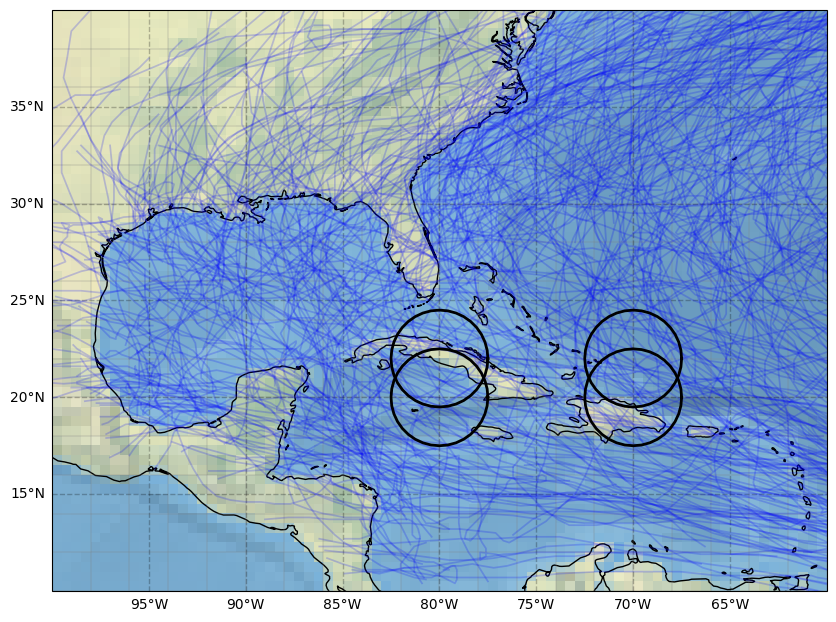

In [38]:
importlib.reload(cheer_utils)

fig, ax = plt.subplots(nrows=1,ncols=1,
                       subplot_kw={'projection': ccrs.PlateCarree()},
                       figsize=(10,10))

ax.plot(analysis_grids['circle']['lon_grid'],  analysis_grids['circle']['lat_grid'],  transform=ccrs.PlateCarree(),color='gray',linewidth=.25)
ax.plot(analysis_grids['circle']['lon_grid'].T,analysis_grids['circle']['lat_grid'].T,transform=ccrs.PlateCarree(),color='gray',linewidth=.25)

ax.grid(True)
ax.stock_img()
#ax[i].background_img(name='BM', resolution='low')
ax.coastlines()

gl=ax.gridlines(draw_labels=True, linewidth=1, color='k', alpha=0.25, linestyle='--')
gl.top_labels = False
gl.right_labels = False
gl.xlocator = mticker.FixedLocator(np.arange(-120, 0,5))

kwargs={"color":'b',
        "alpha":0.2,
        "linewidth":1.25,
        "clip_on":True}
cheer_utils.plot_tracks(DF['ibtracs'],ax,kwargs)

nx  = analysis_grids['circle']['lon_bins'].shape[0]
ny  = analysis_grids['circle']['lat_bins'].shape[0]

for i in [10,11]: #range(ny-1):

    latc=analysis_grids['circle']['lat_bins'][i]
    #latc2=grid_dict['lat_bins'][i+1]

    for j in [10,15]: #range(nx-1):

        lonc=analysis_grids['circle']['lon_bins'][j]
        #lonc2=grid_dict['lon_bins'][j+1]

        cirx = analysis_grids['circle']['rad']*np.cos(analysis_grids['circle']['cangles'])+lonc
        ciry = analysis_grids['circle']['rad']*np.sin(analysis_grids['circle']['cangles'])+latc
        ax.plot(cirx,ciry, linewidth=2, color='k', transform=ccrs.PlateCarree())

ax.set_extent([-100, -60, 10, 40], crs=ccrs.PlateCarree())

## Plot genesis circle counts


vmax=0.5, nc=11
levels=[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
levels=[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
levels=[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


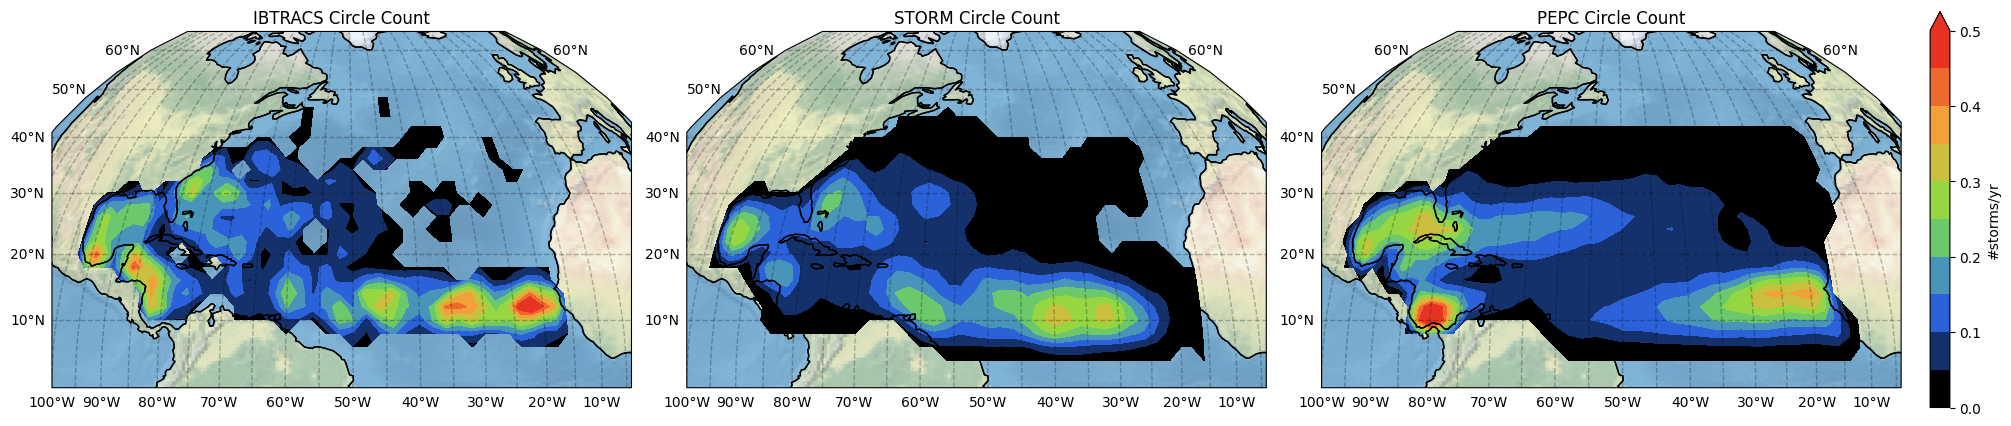

In [39]:
importlib.reload(cheer_utils)

fig, ax = plt.subplots(nrows=1,ncols=3,
                       subplot_kw={'projection': projection,'aspect': 1},
                       figsize=(20,8), 
                       constrained_layout=True,
                       sharey=True)

vmax, nc=0.5, 11
#vmax=np.ceil(np.nanmax(ygrid_ib)/10)*10
#nc=int(np.round(vmax/10))+1
print(f'vmax={vmax}, nc={nc}')
#cbstr='#storms/100y'
cbstr='#storms/yr'
#tstr=[ 'IBTrACS Circle count, September','STORM Circle count, September','PEPC Circle count, September',]
tstr=[f'{s.upper()} Circle Count' for s in setnames]

#levels=np.arange(0,11)
cbadd=[False, False, True]

for i,setname in enumerate(counts_sq.keys()):
    data=counts_cr_g[setname]
    axm, cb=cheer_utils.spatial_density_plot_contours(analysis_grids['circle']['lon_grid'],
                                                      analysis_grids['circle']['lat_grid'],
                                                      data,ax[i],fig, 
                                                      cmap=cmapnoaa_10, vmin=0, vmax=vmax, 
                                                      cbstr=cbstr, tstr=tstr[i],
                                                      levels=None, nc=nc,
                                                      addcolorbar=cbadd[i],filled=True,cbshfc=0.5)
fig.savefig("Genesis_rates.png")

## Plot genesis square counts


0.5681818181818182
0.412
0.5135897435897436
vmax=0.5, nc=11
levels=[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
levels=[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]
levels=[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5 ]


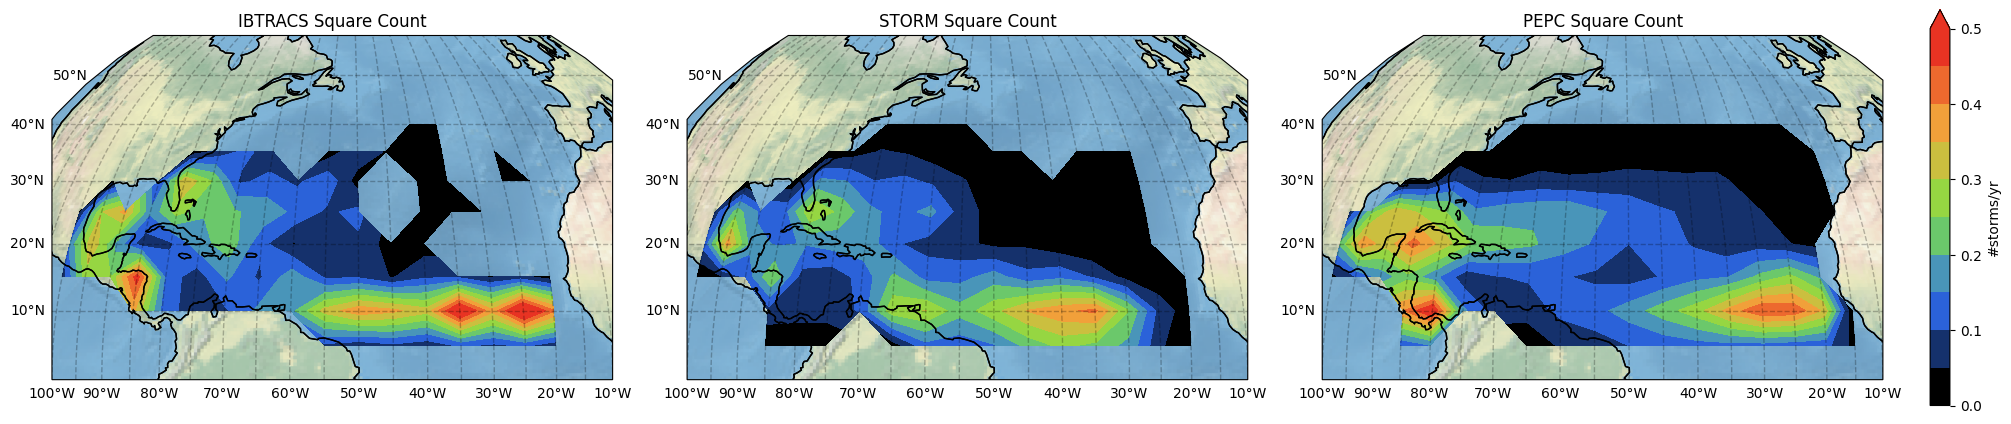

In [42]:
for i,setname in enumerate(counts_sq.keys()):
    data=counts_sq_g[setname]
    print(data.max())

importlib.reload(cheer_utils)

fig, ax = plt.subplots(nrows=1,ncols=3,
                       subplot_kw={'projection': projection,'aspect': 1},
                       figsize=(20,8), 
                       constrained_layout=True,
                       sharey=True)

vmax, nc=0.5, 11
#vmax=np.ceil(np.nanmax(ygrid_ib)/10)*10
#nc=int(np.round(vmax/10))+1
print(f'vmax={vmax}, nc={nc}')
#cbstr='#storms/100y'
cbstr='#storms/yr'
tstr=[f'{s.upper()} Square Count' for s in setnames]

#levels=np.arange(0,11)
cbadd=[False, False, True]

for i,setname in enumerate(counts_sq.keys()):
    data=counts_sq_g[setname]
    axm, cb=cheer_utils.spatial_density_plot_contours(analysis_grids['square']['lon_grid'],
                                                      analysis_grids['square']['lat_grid'],
                                                      data,ax[i],fig, 
                                                      cmap=cmapnoaa_10, vmin=0, vmax=vmax, 
                                                      cbstr=cbstr, tstr=tstr[i],
                                                      levels=None, nc=nc,
                                                      addcolorbar=cbadd[i],filled=True,cbshfc=0.5)
fig.savefig("Genesis_rates_5sq.png")

## Plot raw circle counts


In [ ]:
for i,setname in enumerate(counts_sq.keys()):
    data=counts_cr[setname]
    print(data.max())

In [ ]:
importlib.reload(cheer_utils)

fig, ax = plt.subplots(nrows=1,ncols=3,
                       subplot_kw={'projection': projection,'aspect': 1},
                       figsize=(20,8), 
                       constrained_layout=True,
                       sharey=True)

vmax, nc=200, 11

#vmax=np.ceil(np.nanmax(ygrid_ib)/10)*10
#nc=int(np.round(vmax/10))+1
print(f'vmax={vmax}, nc={nc}')
cbstr='#storms/100y'
#cbstr='#storms/yr'
#tstr=[ 'IBTrACS Circle count, September','STORM Circle count, September','PEPC Circle count, September',]
tstr=[f'{s.upper()} Circle Count' for s in setnames]
#levels=[0, 10, 30, 50, 70]

for i,setname in enumerate(counts_sq.keys()):
    data=counts_cr[setname]
    axm, cb=cheer_utils.spatial_density_plot_contours(analysis_grids['circle']['lon_grid'],
                                                      analysis_grids['circle']['lat_grid'],
                                                      data,ax[i],fig, 
                                                      cmap=cmapnoaa_10, vmin=0, vmax=vmax, 
                                                      cbstr=cbstr, tstr=tstr[i],
                                                      levels=None, nc=nc,
                                                      addcolorbar=cbadd[i],filled=True,cbshfc=0.5)
fig.savefig("100yr_Densities.png")

In [ ]:
for i,setname in enumerate(counts_sq.keys()):
    data=counts_sq[setname]
    print(data.max())

In [ ]:
importlib.reload(cheer_utils)

fig, ax = plt.subplots(nrows=1,ncols=3,
                       subplot_kw={'projection': projection,'aspect': 1},
                       figsize=(20,8), 
                       constrained_layout=True,
                       sharey=True)

vmax, nc=200, 11

#vmax=np.ceil(np.nanmax(ygrid_ib)/10)*10
#nc=int(np.round(vmax/10))+1
print(f'vmax={vmax}, nc={nc}')
cbstr='#storms/100y'
#cbstr='#storms/yr'
tstr=[f'{s.upper()} Square Count' for s in setnames]

#levels=[0, 10, 30, 50, 70]

for i,setname in enumerate(counts_sq.keys()):
    data=counts_sq[setname]
    axm, cb=cheer_utils.spatial_density_plot_contours(analysis_grids['square']['lon_grid'],
                                                      analysis_grids['square']['lat_grid'],
                                                      data,ax[i],fig, 
                                                      cmap=cmapnoaa_10, vmin=0, vmax=vmax, 
                                                      cbstr=cbstr, tstr=tstr[i],
                                                      levels=None, nc=nc,
                                                      addcolorbar=cbadd[i],filled=True,cbshfc=0.5)
#fig.savefig("Densities.png")

## build / evaluate RBF models for circle counts

In [ ]:
# build rbf model
kwargs={'kernel':'gaussian',
        #neighbors=25,
        'smoothing':0.1,
        'epsilon':0.1,
        'degree':-1}

model_rbf={}
rbf_out={}

for i,setname in enumerate(counts_sq.keys()):

    model_rbf[setname] = sci.RBFInterpolator(analysis_grids['circle']['rbf_grid'],counts_cr[setname].flatten(),**kwargs)

    yflat = model_rbf[setname](analysis_grids['circle']['rbf_grid'])
    yflat = np.where(yflat<1,np.nan,yflat)
    rbf_out[setname] = yflat.reshape(analysis_grids['circle']['lon_grid'].shape)
    

model_rbf_sq={}
rbf_out_sq={}

for i,setname in enumerate(counts_sq.keys()):

    model_rbf_sq[setname] = sci.RBFInterpolator(analysis_grids['square']['rbf_grid'],counts_sq[setname].flatten(),**kwargs)

    yflat = model_rbf_sq[setname](analysis_grids['square']['rbf_grid'])
    yflat = np.where(yflat<1,np.nan,yflat)
    rbf_out_sq[setname] = yflat.reshape(analysis_grids['square']['lon_grid'].shape)

In [ ]:
importlib.reload(cheer_utils)

fig, ax = plt.subplots(nrows=1,ncols=3,
                       subplot_kw={'projection': projection,'aspect': 1},
                       constrained_layout=True,
                       figsize=(24,12),
                       sharey=True)

vmax, nc=200, 8
#vmax=np.ceil(np.nanmax(ygrid_ib)/10)*10
#nc=int(np.round(vmax/10))+1
print(f'vmax={vmax}, nc={nc}')
cbstr='#storms/100y'
#tstr=[ 'IBTrACS Circle count, September','STORM Circle count, September','PEPC Circle count, September',]
tstr=[f'{s.upper()} Circle Count' for s in setnames]

levels=[0, 10, 30, 50, 70, 100, 150, 200]

for i,setname in enumerate(counts_sq.keys()):
    data=rbf_out[setname]
    axm, cb=cheer_utils.spatial_density_plot_contours(analysis_grids['circle']['lon_grid'],
                                                      analysis_grids['circle']['lat_grid'],
                                                      data,ax[i],fig, 
                                                      cmap=cmapnoaa, vmin=0, vmax=vmax, 
                                                      cbstr='#storms/100y', tstr=tstr[i],
                                                      levels=levels, nc=nc,
                                                      addcolorbar=cbadd[i], filled=True, cbshfc=0.5)


## Plot events w/i grid

In [ ]:
importlib.reload(cheer_utils)

#vmax=np.ceil(np.nanmax(counts_ib)/10)*10
#nc=int(np.round(vmax/10))+1

vmax,nc=2, 10
print(f'vmax={vmax}, nc={nc}')
ThisCmap=cheer_utils.discrete_cmap(nc, 'RdBu_r')

tstr=f'IBTrACS, Genesis, nyears={nyears["ibtracs"]}' # , September'
cbstr='storms/yr'
levels=[0, 10, 30, 50, 70]

fig, ax = plt.subplots(nrows=1,ncols=1,
                       subplot_kw={'projection': projection,'aspect': 1},
                       figsize=(10,10),
                       constrained_layout=True,
                       sharey=True)

#data=counts_sq['ibtracs']/100
data=counts_sq_g['ibtracs']/nyears['ibtracs']


axm0, cb=cheer_utils.spatial_density_plot(analysis_grids['square']['lon_bins'],
                                          analysis_grids['square']['lat_bins'],
                                          analysis_grids['square']['dx'],
                                          analysis_grids['square']['dy'],
                                          data,
                                          ax,fig,
                                          cmap=ThisCmap, vmin=0, vmax=vmax, cbstr=cbstr, tstr=tstr, 
                                          shading='nearest', addcolorbar=True, cbshfc=0.5)

# kwargs={"transform": ccrs.PlateCarree(),
#         "color":'w',
#         "fontsize":12,
#         "horizontalalignment":'center', 
#         "verticalalignment":'center','clip_on':True}
# for i in range(analysis_grids['square']['lat_bins'].shape[0]-1):
#     for j in range(analysis_grids['square']['lon_bins'].shape[0]-1):
#         if np.isfinite(counts_sq['ibtracs'][i][j]):
#             ax.text(analysis_grids['square']['lon_bins'][j],
#                     analysis_grids['square']['lat_bins'][i],
#                     f'{counts_sq["ibtracs"][i][j]:.0f}',
#                     **kwargs)   
# ax.clabel(axm, axm.levels, inline=False,  fontsize=10, colors='k')
#f'{ygrid[i][j]:.0f}'
#ax.set_extent([-80, -60, 20, 40] ,crs=ccrs.PlateCarree())
fig.savefig("IBTrACS_storms_per_yr.png")

In [ ]:
for i,setname in enumerate(counts_sq.keys()):
    data=counts_sq[setname]/100
    #data=counts_sq_g[setname]/nyears[setname]
    print(f'{setname}:{data.max()}')

#nc=np.max([maxcounts_ib,maxcounts_st,maxcounts_pc])+1

vmax,nc=2, 10
# print(f'vmax={vmax}, nc={nc}')
# ThisCmap=cheer_utils.discrete_cmap(nc, 'jet')

fig, ax = plt.subplots(nrows=1,ncols=3,
                       subplot_kw={'projection': projection,'aspect': 1},
                       figsize=(24,12),
                       sharey=True, constrained_layout=True)

#tstr=f'IBTrACS, nyears={nyears["ibtracs"]}'
#tstr=[ 'IBTrACS SQ count, September','STORM SQ count, September','PEPC SQ count, September',]
tstr=[f'{s.upper()} Square Count' for s in setnames]

cbstr='storms/yr'
cbadd=[False, False, True]

for i,setname in enumerate(counts_sq.keys()):
    data=counts_sq[setname]/100
    axm, cb=cheer_utils.spatial_density_plot(analysis_grids['square']['lon_bins'],
                                             analysis_grids['square']['lat_bins'],
                                             analysis_grids['square']['dx'],
                                             analysis_grids['square']['dy'],
                                             data,
                                             ax[i],fig,
                                             cmap=ThisCmap, vmin=0, vmax=vmax, cbstr=cbstr, tstr=tstr[i], 
                                             shading='nearest', addcolorbar=cbadd[i],cbshfc=0.35)

#fig.suptitle('Annual Counts',fontsize=28,y=0.85);
#fig.savefig("September_Counts_100yr.png")
fig.savefig("Counts_pyr.png")

In [ ]:
for i,setname in enumerate(counts_sq.keys()):
    data=counts_sq_g[setname]/nyears[setname]
    print(f'{setname}:{data.max()}')

In [ ]:
# Genesis plots

#nc=np.max([maxcounts_ib,maxcounts_st,maxcounts_pc])+1

vmax,nc=.6, 12
# print(f'vmax={vmax}, nc={nc}')
# ThisCmap=cheer_utils.discrete_cmap(nc, 'jet')

fig, ax = plt.subplots(nrows=1,ncols=3,
                       subplot_kw={'projection': projection,'aspect': 1},
                       figsize=(24,12),
                       sharey=True, constrained_layout=True)

#tstr=f'IBTrACS, nyears={nyears["ibtracs"]}'
#tstr=[ 'IBTrACS SQ count Genesis, September','STORM SQ count Genesis, September','PEPC SQ count Genesis, September',]
tstr=[f'{s.upper()} Square Count, Genesis' for s in setnames]

for i,setname in enumerate(counts_sq.keys()):
    data=counts_sq_g[setname]/nyears[setname]
    axm, cb=cheer_utils.spatial_density_plot(analysis_grids['square']['lon_bins'],
                                             analysis_grids['square']['lat_bins'],
                                             analysis_grids['square']['dx'],
                                             analysis_grids['square']['dy'],
                                             data,
                                             ax[i],fig,
                                             cmap=ThisCmap, vmin=0, vmax=vmax, cbstr='storms/yr', tstr=tstr[i], 
                                             shading='nearest', addcolorbar=cbadd[i],cbshfc=0.35)

fig.suptitle('Genesis Rates',fontsize=28,y=0.75);
#fig.savefig("Genesis_Counts_per_yr_September.png")
fig.savefig("Genesis_Counts_perYear.png")

## Density plots

In [ ]:
genesis_locations=False
density=False

storms_per_year=False
log10=False
normalized_count=True

cmapName='RdBu_r'

bins=(analysis_grids['square']['lon_bins'],analysis_grids['square']['lat_bins'])
densities={}

if genesis_locations:
    print(f'Computing Genesis Position Counts, Density={density}')
    densities['ibtracs'],      _,      _ = np.histogram2d(DF_G['ibtracs'].Longitude,DF_G['ibtracs'].Latitude, bins=bins, density=density)
    densities['storm'],        _,      _ = np.histogram2d(DF_G['storm'].Longitude,  DF_G['storm'].Latitude,   bins=bins, density=density)
    densities['pepc'],    xedges, yedges = np.histogram2d(DF_G['pepc'].Longitude,   DF_G['pepc'].Latitude,    bins=bins, density=density)
    suptitle="Genesis Locations"
    
else:
    print(f'Computing Track Position Counts, Density={density}')
    densities['ibtracs'],      _,      _ = np.histogram2d(DF['ibtracs'].Longitude,DF['ibtracs'].Latitude, bins=bins, density=density)
    densities['storm'],        _,      _ = np.histogram2d(DF['storm'].Longitude,  DF['storm'].Latitude,   bins=bins, density=density)
    densities['pepc'],    xedges, yedges = np.histogram2d(DF['pepc'].Longitude,   DF['pepc'].Latitude,    bins=bins, density=density)
    suptitle="Track Positions"

for i,setname in enumerate(counts_sq.keys()):
    data=densities[setname]
    print(f'{setname:8s} : {data.min():0.5f} : {data.max():0.5f}')

nc=10
vmin=[0,0,0]
vmax=[0,0,0]

temp={}

fname='StormOccurrence'

if makeplots:

    fig, ax = plt.subplots(nrows=1,ncols=3,
                           subplot_kw={'projection': projection,'aspect': 1},
                           figsize=(24,12),
                           sharey=True, constrained_layout=True)  
    
    if density:
        
        tol=1e-4

        temp['ibtracs']=np.where(densities['ibtracs'].copy().T < tol, np.nan, densities['ibtracs'].T)
        temp['storm']=np.where(densities['storm'].copy().T < tol, np.nan, densities['storm'].T)
        temp['pepc']=np.where(densities['pepc'].copy().T < tol, np.nan, densities['pepc'].T)

        fname=fname+'_PointDensity'

        if log10:
            
            cbstr=f'log10 ({cbstr})'
            print(cbstr)

            temp['ibtracs']=np.log10(temp['ibtracs'])
            temp['storm']=np.log10(temp['storm'])
            temp['pepc']=np.log10(temp['pepc'])
            
            vmin[0], vmax[0] = -4, -2.8
            vmin[1], vmax[1] = vmin[0], vmax[0]
            vmin[2], vmax[2] = vmin[0], vmax[0]
            nc=12
            
            fname=fname+'_log10'
           
        else:
            
            cbstr='Point density (n/N/area)'
            print(cbstr)
            
            vmin[0], vmax[0] = tol, 1e-3
            vmin[1], vmax[1] = vmin[0], vmax[0]
            vmin[2], vmax[2] = vmin[0], vmax[0]
            nc=10
            
    elif storms_per_year:
        
        cbstr='#Storms/yr'
        print(cbstr)
        
        fname=fname+'_StormsPerYear'
        
        tol=1
        temp['ibtracs'] = np.where(densities['ibtracs'].copy().T < tol, np.nan, densities['ibtracs'].T)/nyears['ibtracs']
        temp['storm']   = np.where(densities['storm'].copy().T < tol,   np.nan, densities['storm'].T)/nyears['storm']
        temp['pepc']    = np.where(densities['pepc'].copy().T < tol,    np.nan, densities['pepc'].T)/nyears['pepc']

        
        if genesis_locations: 
            nc=10
            vmin[0],vmax[0] = 0, 0.5
            vmin[1],vmax[1] = vmin[0],vmax[0]
            vmin[2],vmax[2] = vmin[0],vmax[0]
 
        else:
            nc=10
            vmin[0],vmax[0] = 0, 10
            vmin[1],vmax[1] = vmin[0],vmax[0]
            vmin[2],vmax[2] = vmin[0],vmax[0]
 
    else:
        
        cbstr='Count'
        nc=10

        fname=fname+'_Count'
        
        temp['ibtracs'] = density_ib.T.copy()
        temp['storm']   = density_st.T.copy()
        temp['pepc']    = density_pc.T.copy()
        
        tol=1
        temp['ibtracs'] = np.where(temp['ibtracs'] < tol, np.nan, temp['ibtracs'])
        temp['storm']   = np.where(temp['storm']   < tol, np.nan, temp['storm'])
        temp['pepc']    = np.where(temp['pepc']    < tol, np.nan, temp['pepc'])

        if normalized_count:

            cbstr=f'Normalized {cbstr}'
            print(cbstr)
            fname=fname+'Normalized'

            temp['ibtracs'] = temp['ibtracs']/np.nanmax(temp['ibtracs'])
            temp['storm']   = temp['storm']/np.nanmax(temp['storm'])
            temp['pepc']    = temp['pepc']/np.nanmax(temp['pepc'])
            
            vmin[0],vmax[0] = 0, 1
            vmin[1],vmax[1] = vmin[0],vmax[0]
            vmin[2],vmax[2] = vmin[0],vmax[0]

        else:
            
            print(cbstr)

            # vmin0, vmax0 = 0, np.power(10,np.ceil(np.log10(np.nanmax(tempib))))
            # vmin1, vmax1 = 0, np.power(10,np.ceil(np.log10(np.nanmax(tempst))))
            # vmin2, vmax2 = 0, np.power(10,np.ceil(np.log10(np.nanmax(temppc))))
            vmin[0],vmax[0] = 0, 500
            vmin[1],vmax[1] = 0, 5000            
            vmin[2],vmax[2] = 0, 30000            
           
    tstr=[f'IBTrACS \n{df_ib["Year"].min()}-{df_ib["Year"].max()}',
          f'STORM\n nyears={nyears["storm"]}, ensnum={ensnum}, {int(DF["storm"]["Year"].min())}-{int(DF["storm"]["Year"].max())}',
          f'PEPC\n  nyears={nyears["pepc"]} \nsets {setnums}']
        
    #ThisCmap=cheer_utils.discrete_cmap(nc, 'viridis')
    #ThisCmap=cheer_utils.discrete_cmap(nc, 'YlGnBu_r')
    ThisCmap=cheer_utils.discrete_cmap(nc, cmapName)

    for i,setname in enumerate(counts_sq.keys()):
        data=temp[setname]
        print(f'{setname:8s} : {np.nanmin(data):0.5f} : {np.nanmax(data):0.5f}')
    
    for i,setname in enumerate(counts_sq.keys()):
        axm=cheer_utils.spatial_density_plot(analysis_grids['square']['lon_bins'],
                                             analysis_grids['square']['lat_bins'],
                                             analysis_grids['square']['dx'],
                                             analysis_grids['square']['dy'],
                                             temp[setname],
                                             ax[i], fig, cmap=ThisCmap, vmin=vmin[i], vmax=vmax[i],
                                             cbstr=cbstr, tstr=tstr[i],
                                             shading='flat', addcolorbar=True,cbshfc=0.35)
    
    # hex grid
    # axm.append(ax[0].hexbin(df_gib.Longitude,df_gib.Latitude, cmap=ThisCmap, bins='log' )) # ,  vmin=vmin, vmax=vmax) 
    # axm.append(ax[1].hexbin(df_gst.Longitude,df_gst.Latitude, cmap=ThisCmap, bins='log' )) # ,  vmin=vmin, vmax=vmax) 
        
#     ax[0].plot(nc_circ['cirx'],nc_circ['ciry'],transform=ccrs.PlateCarree(),color='k')
#     ax[1].plot(nc_circ['cirx'],nc_circ['ciry'],transform=ccrs.PlateCarree(),color='k')
#     ax[2].plot(nc_circ['cirx'],nc_circ['ciry'],transform=ccrs.PlateCarree(),color='k')
    
fig.suptitle(fname,fontsize=28,y=0.85);
fig.savefig(f'{fname}.png')

In [ ]:
# annotate with text for counts in boxes
# kwargs={"transform": ccrs.PlateCarree(),
#         "color":'w',
#         "fontsize":12,
#         "horizontalalignment":'center', 
#         "verticalalignment":'center','clip_on':True}
# for i in range(grid_dict['lat_bins'].shape[0]-1):
#     for j in range(grid_dict['lon_bins'].shape[0]-1):
#         if np.isfinite(counts_ib[i][j]):
# #            ax.text(lon_bins[j],lat_bins[i],f'{counts_ib[i][j]:.0f}',**kwargs)          
#             ax.text(lon_bins[j]+dx/2,lat_bins[i]+dy/2,f'{counts_ib[i][j]:.0f}',**kwargs)          

# kwargs={"transform": ccrs.PlateCarree(),
#         "color":'w',
#         "fontsize":6,
#         "horizontalalignment":'center', 
#         "verticalalignment":'center','clip_on':True}
# for i in range(lat_bins2.shape[0]-1):
#     for j in range(lon_bins2.shape[0]-1):
#         if np.isfinite(ygrid[i][j]):
#             ax.text(lon_bins2[j],lat_bins2[i],f'{ygrid[i][j]:.0f}',**kwargs)                
            
# # add tracks for reference / debugging.  
# # This takes a long time when there are many years in PEPC, STORM.
# kwargs={"transform": ccrs.PlateCarree(),
#         "color":'k',
#         "alpha":0.5,
#         "linewidth":1,
#         'clip_on':True}

# IDX=np.unique(df_ib.index).astype(int)   
# for i,idx in enumerate(IDX): 
#     x=df_ib.loc[df_ib.index==idx].Longitude.values
#     y=df_ib.loc[df_ib.index==idx].Latitude.values
#     ax.plot(x, y, **kwargs)
    # for j in range(x.shape[0]):
    #     ax.text(x[j],y[j],idx,transform=ccrs.PlateCarree(),clip_on=True)
    
    
    

# kwargs={"transform": ccrs.PlateCarree()}
# for i in [10,11]: #range(ny-1):

#     latc=grid_dict['lat_bins'][i]
#     #latc2=grid_dict['lat_bins'][i+1]

#     for j in [10]: #range(nx-1):

#         lonc=grid_dict['lon_bins'][j]
#         #lonc2=grid_dict['lon_bins'][j+1]

#         cirx = rad*np.cos(a)+lonc
#         ciry = rad*np.sin(a)+latc
#         ax.plot(cirx,ciry, linewidth=2, color='k', transform=ccrs.PlateCarree())
#         ax.text(lon_bins[j],lat_bins[i],f'{cc[i][j]:.0f}',**kwargs)   

# kwargs={"transform": ccrs.PlateCarree(),
#         "color":'w',
#         "fontsize":12,
#         "horizontalalignment":'center', 
#         "verticalalignment":'center','clip_on':True}
# for i in range(lat_bins.shape[0]-1):
#     for j in range(lon_bins.shape[0]-1):
#         if np.isfinite(ygrid[i][j]):
#             ax.text(lon_bins[j],lat_bins[i],f'{ygrid[i][j]:.0f}',**kwargs)   
#ax.set_extent([-100, -60, 0, 40], crs=ccrs.PlateCarree())

#ax.set_extent([df_temp['Longitude'].min(), df_temp['Longitude'].max(), df_temp['Latitude'].min(), df_temp['Latitude'].max()], crs=ccrs.PlateCarree())

In [ ]:
# importlib.reload(cheer_utils)

# fig, ax = plt.subplots(nrows=1,ncols=1,
#                        subplot_kw={'projection': projection},
#                        figsize=(10,10))


# vmax, nc=100, 5
# #vmax=np.ceil(np.nanmax(ygrid)/10)*10
# #nc=int(np.round(vmax/10))+1
# print(f'vmax={vmax}, nc={nc}')
# levels=[0, 10, 30, 50, 70]
# axm, cb=cheer_utils.spatial_density_plot_contours(analysis_grids['circle']['lon_grid'],
#                                                   analysis_grids['circle']['lat_grid'],
#                                                   rbf_out['ibtracs'],
#                                                   ax, fig, cmap=cmapnoaa, vmin=0, vmax=vmax, 
#                                                   cbstr='#storms/100y', tstr='IBTrACS Circle count, September',nc=nc, 
#                                                   levels=levels,
#                                                   addcolorbar=True,filled=True)
# #ax.clabel(axm, axm.levels, inline=True,  fontsize=12, colors='k')

In [ ]:
# a=np.arange(0,370,10)*np.pi/180
# rad=3
# lo=-76.5
# la=34.75
# # test track screening circle
# # rad= .3
# # lo=-77.75
# # la=35
# nc_circ={'lo': lo,
#          'la': la, 
#          'rad': rad,
#          'cirx': rad*np.cos(a)+lo,
#          'ciry': rad*np.sin(a)+la}

# rad=3
# lo=-94
# la=29.5
# tx_circ={'lo': lo,
#          'la':  la,
#          'rad': rad,
#          'cirx': rad*np.cos(a)+lo,
#          'ciry': rad*np.sin(a)+la}

# df_ib['dist2nc']=np.sqrt(np.square(df_ib['Longitude']-nc_circ['lo']) + np.square(df_ib['Latitude']-nc_circ['la']))
# df_ib['dist2tx']=np.sqrt(np.square(df_ib['Longitude']-tx_circ['lo']) + np.square(df_ib['Latitude']-tx_circ['la']))
# df_ib['HollandB']=cheer_utils.HbFromRmwLat(df_ib['RMW'],df_ib['Latitude'])
# df_ib['DeltaP']=-(df_ib['Min_pres']-1024)

# df_st['dist2nc']=np.sqrt(np.square(df_st['Longitude']-nc_circ['lo']) + np.square(df_st['Latitude']-nc_circ['la']))
# df_st['dist2tx']=np.sqrt(np.square(df_st['Longitude']-tx_circ['lo']) + np.square(df_st['Latitude']-tx_circ['la']))
# df_st['HollandB']=cheer_utils.HbFromRmwLat(df_st['RMW'],df_st['Latitude'])
# df_st['DeltaP']=-(df_st['Min_pres']-1013)

# df_pc['dist2nc']=np.sqrt(np.square(df_pc['Longitude']-nc_circ['lo']) + np.square(df_pc['Latitude']-nc_circ['la']))
# df_pc['dist2tx']=np.sqrt(np.square(df_pc['Longitude']-tx_circ['lo']) + np.square(df_pc['Latitude']-tx_circ['la']))